# Proiect Big Data 2022
### Analiza setului de date oferit de UCI(University of California Irvine) cu privire la calitatea vinului alb in functie de anumiti factori.
---

Dobre Mihaela Beatrice, grupa 405

# Introducere

Următoarea analiză este realizată pe setul de date *Wine Quality* ce poate fi găsit la următorul link: https://archive.ics.uci.edu/ml/datasets/Wine+Quality

În setul de date se vor regăsi următoarele atribute:
1. fixed acidity
2. volatile acidity
3. citric acid
4. residual sugar
5. chlorides
6. free sulfur dioxide
7. total sulfur dioxide
8. density
9. pH
10. sulphates
11. alcohol

Variabila de output (bazată pe toate celelalte): <br/>
12 - quality (scor între 0 și 10)

In [1]:
!pip install pyspark

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 281.3 MB 30 kB/s 
     |████████████████████████████████| 199 kB 51.4 MB/s 
  Created wheel for pyspark: filename=pyspark-3.3.0-py2.py3-none-any.whl size=281764026 sha256=d5fca926c96d63f0ebe41e5ff7e4887ca631561b6016ae8408616381cc045f39
  Stored in directory: /root/.cache/pip/wheels/7a/8e/1b/f73a52650d2e5f337708d9f6a1750d451a7349a867f928b885
Successfully built pyspark


Importarea librăriilor necesare

In [2]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
import pandas as pd
import numpy as np

from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StandardScaler

from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import LinearSVC, OneVsRest

from pyspark.ml import Pipeline

Crearea unui obiect SparkSession și crearea unui Dataframe prin citirea setului de date CSV:

In [3]:
spark = SparkSession.builder.appName("Project_AirQuality").getOrCreate()    
df = spark.createDataFrame(pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-white.csv", delimiter=';'))

Afișarea numărului de instanțe din dataset și a primelor date.

In [4]:
df.count()

4898

In [5]:
df.show()

+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+----+---------+-------+-------+
|fixed acidity|volatile acidity|citric acid|residual sugar|chlorides|free sulfur dioxide|total sulfur dioxide|density|  pH|sulphates|alcohol|quality|
+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+----+---------+-------+-------+
|          7.0|            0.27|       0.36|          20.7|    0.045|               45.0|               170.0|  1.001| 3.0|     0.45|    8.8|      6|
|          6.3|             0.3|       0.34|           1.6|    0.049|               14.0|               132.0|  0.994| 3.3|     0.49|    9.5|      6|
|          8.1|            0.28|        0.4|           6.9|     0.05|               30.0|                97.0| 0.9951|3.26|     0.44|   10.1|      6|
|          7.2|            0.23|       0.32|           8.5|    0.058|               47.0|           

# Analiza datelor cu ajutorul Dataframes și Spark SQL.

Afișarea unor statistici referitoare la setul de date și a schemei caracteristicilor.

In [6]:
df.describe().show()

+-------+------------------+-------------------+-------------------+-----------------+-------------------+-------------------+--------------------+--------------------+------------------+-------------------+------------------+-----------------+
|summary|     fixed acidity|   volatile acidity|        citric acid|   residual sugar|          chlorides|free sulfur dioxide|total sulfur dioxide|             density|                pH|          sulphates|           alcohol|          quality|
+-------+------------------+-------------------+-------------------+-----------------+-------------------+-------------------+--------------------+--------------------+------------------+-------------------+------------------+-----------------+
|  count|              4898|               4898|               4898|             4898|               4898|               4898|                4898|                4898|              4898|               4898|              4898|             4898|
|   mean| 6.85478766

In [7]:
df.printSchema()

root
 |-- fixed acidity: double (nullable = true)
 |-- volatile acidity: double (nullable = true)
 |-- citric acid: double (nullable = true)
 |-- residual sugar: double (nullable = true)
 |-- chlorides: double (nullable = true)
 |-- free sulfur dioxide: double (nullable = true)
 |-- total sulfur dioxide: double (nullable = true)
 |-- density: double (nullable = true)
 |-- pH: double (nullable = true)
 |-- sulphates: double (nullable = true)
 |-- alcohol: double (nullable = true)
 |-- quality: long (nullable = true)



Afișarea vinurilor cu un *pH* mai mare sau egal cu 3 și cu o *concentrație de alcool* mai mică de 10, ordonate descrescator în funcție de calitate.

In [8]:
df.createOrReplaceTempView("wines")
queryDF = spark.sql("SELECT * FROM wines WHERE ph >= 3 and alcohol < 10 ORDER BY quality DESC")
queryDF.show()

+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+----+---------+-------+-------+
|fixed acidity|volatile acidity|citric acid|residual sugar|chlorides|free sulfur dioxide|total sulfur dioxide|density|  pH|sulphates|alcohol|quality|
+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+----+---------+-------+-------+
|          7.6|             0.2|        0.3|          14.2|    0.056|               53.0|               212.5|  0.999|3.14|     0.46|    8.9|      8|
|          7.6|             0.2|        0.3|          14.2|    0.056|               53.0|               212.5|  0.999|3.14|     0.46|    8.9|      8|
|          7.6|             0.2|        0.3|          14.2|    0.056|               53.0|               212.5|  0.999|3.14|     0.46|    8.9|      8|
|          8.1|            0.17|       0.44|          14.1|    0.053|               43.0|           

Afișarea numărului de tipuri de vin corespunzătoare fiecărei calități în ordinea crescătoare a calității.

In [9]:
grouped = df.groupBy(df.quality).count().sort("quality")
grouped.show(truncate=False)

+-------+-----+
|quality|count|
+-------+-----+
|3      |20   |
|4      |163  |
|5      |1457 |
|6      |2198 |
|7      |880  |
|8      |175  |
|9      |5    |
+-------+-----+



Afișarea cantității de *zahăr rezidual* pentru tipurile de vin cu concentrația maximă de alcool.

In [10]:
maxAlcohol = spark.sql("SELECT MAX(alcohol) FROM wines").collect()[0][0]
df.select('residual sugar').filter(col('alcohol') == maxAlcohol).collect()

[Row(residual sugar=1.6)]

# Pregătirea și curățarea datelor

Înlocuirea spațiilor din numele caracteristicilor cu _ pentru consistență și claritate.

In [11]:
cols = df.columns
for c in cols:
    df = df.withColumnRenamed(c, c.replace(' ', '_'))

df.columns

['fixed_acidity',
 'volatile_acidity',
 'citric_acid',
 'residual_sugar',
 'chlorides',
 'free_sulfur_dioxide',
 'total_sulfur_dioxide',
 'density',
 'pH',
 'sulphates',
 'alcohol',
 'quality']

După cum s-a putut observa, range-ul calităților este de la 3 la 9, așă că vom mapa coloana *quality* pentru a fi între 0 și 6.

In [12]:
df = df.withColumn('quality', col('quality') - 3)
df.show()

+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+----+---------+-------+-------+
|fixed_acidity|volatile_acidity|citric_acid|residual_sugar|chlorides|free_sulfur_dioxide|total_sulfur_dioxide|density|  pH|sulphates|alcohol|quality|
+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+----+---------+-------+-------+
|          7.0|            0.27|       0.36|          20.7|    0.045|               45.0|               170.0|  1.001| 3.0|     0.45|    8.8|      3|
|          6.3|             0.3|       0.34|           1.6|    0.049|               14.0|               132.0|  0.994| 3.3|     0.49|    9.5|      3|
|          8.1|            0.28|        0.4|           6.9|     0.05|               30.0|                97.0| 0.9951|3.26|     0.44|   10.1|      3|
|          7.2|            0.23|       0.32|           8.5|    0.058|               47.0|           

Testarea nulității caracteristicilor sau a valorilor lipsă. Se poate observa că nu există astfel de valori în setul de date.

In [13]:
df.select([count(when(isnan(col(c)) | col(c).isNull(), c)).alias(c) for c in df.columns]).show()

+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+---+---------+-------+-------+
|fixed_acidity|volatile_acidity|citric_acid|residual_sugar|chlorides|free_sulfur_dioxide|total_sulfur_dioxide|density| pH|sulphates|alcohol|quality|
+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+---+---------+-------+-------+
|            0|               0|          0|             0|        0|                  0|                   0|      0|  0|        0|      0|      0|
+-------------+----------------+-----------+--------------+---------+-------------------+--------------------+-------+---+---------+-------+-------+



Ștergerea duplicatelor din setul de date

In [14]:
print(df.count())
if df.count() > df.dropDuplicates(df.columns).count():
    df = df.dropDuplicates(df.columns)
print(df.count())

4898
3961


Reprezentarea matricei de corelație.

In [15]:
df.toPandas().corr().style.background_gradient("BuPu")

,fixed_acidity,volatile_acidity,citric_acid,residual_sugar,chlorides,free_sulfur_dioxide,total_sulfur_dioxide,density,pH,sulphates,alcohol,quality
fixed_acidity,1.000000,-0.019214,0.298959,0.083620,0.024036,-0.058396,0.082425,0.266091,-0.431274,-0.017453,-0.110788,-0.124636
volatile_acidity,-0.019214,1.000000,-0.163228,0.098340,0.086287,-0.102471,0.102315,0.060603,-0.046954,-0.021150,0.046815,-0.190678
citric_acid,0.298959,-0.163228,1.000000,0.106269,0.132590,0.091681,0.122845,0.160076,-0.183015,0.049442,-0.076514,0.007065
residual_sugar,0.083620,0.098340,0.106269,1.000000,0.076091,0.306835,0.409583,0.820498,-0.165997,-0.020503,-0.398167,-0.117339
chlorides,0.024036,0.086287,0.132590,0.076091,1.000000,0.101272,0.191145,0.253088,-0.090573,0.017871,-0.356928,-0.217739
free_sulfur_dioxide,-0.058396,-0.102471,0.091681,0.306835,0.101272,1.000000,0.619437,0.294638,-0.007750,0.037932,-0.251768,0.010507
total_sulfur_dioxide,0.082425,0.102315,0.122845,0.409583,0.191145,0.619437,1.000000,0.536868,0.008239,0.136544,-0.446643,-0.183356
density,0.266091,0.060603,0.160076,0.820498,0.253088,0.294638,0.536868,1.000000,-0.063734,0.082048,-0.760162,-0.337805
pH,-0.431274,-0.046954,-0.183015,-0.165997,-0.090573,-0.007750,0.008239,-0.063734,1.000000,0.142353,0.093095,0.123829
sulphates,-0.017453,-0.021150,0.049442,-0.020503,0.017871,0.037932,0.136544,0.082048,0.142353,1.000000,-0.022850,0.053200


Reprezentarea legăturii și a influenței clorurilor pentru calitatea vinului.

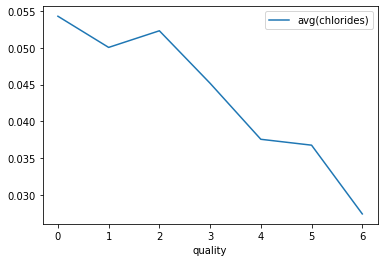

In [16]:
grouped = df.groupBy(df.quality).mean().sort("quality")
grouped.toPandas().plot(x="quality", y=['avg(chlorides)'])

Transformarea coloanelor de caracteristici în una singura

In [17]:
cols = df.columns
cols.remove('quality')
va = VectorAssembler(inputCols = cols, outputCol='features')
df = va.transform(df)

Scalarea datelor cu ajutorul StandardScaler

In [18]:
scaler = StandardScaler(inputCol='features', outputCol='scaledFeatures', withStd=True, withMean=False)
scaler_model = scaler.fit(df)
df = scaler_model.transform(df)

# Spark ML

Împărțirea setului de date în date de training(70%) și date de test(30%) cu folosirea unui seed pentru a obține un rezultat consistent.

In [19]:
train, test = df.select('scaledFeatures', 'quality').randomSplit([.7, .3], seed=23)

### Folosirea **Logistic Regression** ca metodă de Machine Learning pentru prezicerea calității vinului.

In [20]:
lr = LogisticRegression(featuresCol='scaledFeatures',labelCol='quality', family='multinomial')
lr_model=lr.fit(train)

Afișarea predicțiilor modelului

In [21]:
pred = lr_model.evaluate(test).predictions
pred.show()

+--------------------+-------+--------------------+--------------------+----------+
|      scaledFeatures|quality|       rawPrediction|         probability|prediction|
+--------------------+-------+--------------------+--------------------+----------+
|[4.38363880848235...|      3|[-6.8597679028750...|[1.39679239522446...|       4.0|
|[5.07579230455851...|      5|[-6.0436617632383...|[2.48278772543737...|       4.0|
|[5.19115122057120...|      2|[-0.5018326979178...|[0.00265520443237...|       2.0|
|[5.30651013658389...|      2|[-1.9433759111739...|[0.00175227754775...|       2.0|
|[5.42186905259659...|      4|[-7.6086946112473...|[2.37352740743097...|       4.0|
|[5.42186905259659...|      2|[-6.8716065846360...|[4.10613438521594...|       4.0|
|[5.53722796860928...|      4|[-5.3632153597002...|[8.13496737121001...|       3.0|
|[5.65258688462198...|      3|[-4.3806771010134...|[6.31909173028991...|       3.0|
|[5.65258688462198...|      3|[-2.6349214337464...|[0.00116217587474...|    

In [22]:
pred = pred.select('quality', 'prediction')
pred.show()

+-------+----------+
|quality|prediction|
+-------+----------+
|      3|       4.0|
|      5|       4.0|
|      2|       2.0|
|      2|       2.0|
|      4|       4.0|
|      2|       4.0|
|      4|       3.0|
|      3|       3.0|
|      3|       3.0|
|      4|       3.0|
|      3|       4.0|
|      5|       3.0|
|      3|       3.0|
|      3|       3.0|
|      3|       3.0|
|      4|       4.0|
|      5|       4.0|
|      3|       3.0|
|      4|       4.0|
|      3|       3.0|
+-------+----------+
only showing top 20 rows



Crearea unui evaluator și evalurea modelului

In [23]:
evaluator = MulticlassClassificationEvaluator(predictionCol='prediction', labelCol='quality',
                                             metricName='accuracy')
evaluator.evaluate(pred)

0.5343258891645989

### Folosirea **Random Forest** ca metodă de ML pentru prezicerea calității vinului.

In [24]:
rf = RandomForestClassifier(featuresCol='scaledFeatures', labelCol='quality', predictionCol='prediction', numTrees=10, seed=42)
rf_model = rf.fit(train)
pred = rf_model.evaluate(test).predictions
pred.show()

+--------------------+-------+--------------------+--------------------+----------+
|      scaledFeatures|quality|       rawPrediction|         probability|prediction|
+--------------------+-------+--------------------+--------------------+----------+
|[4.38363880848235...|      3|[0.02609321415601...|[0.00260932141560...|       3.0|
|[5.07579230455851...|      5|[0.02773137513930...|[0.00277313751393...|       4.0|
|[5.19115122057120...|      2|[0.07025293547032...|[0.00702529354703...|       3.0|
|[5.30651013658389...|      2|[0.01160394265232...|[0.00116039426523...|       2.0|
|[5.42186905259659...|      4|[0.00316455696202...|[3.16455696202531...|       4.0|
|[5.42186905259659...|      2|[0.03703703703703...|[0.00370370370370...|       2.0|
|[5.53722796860928...|      4|[0.03180749987030...|[0.00318074998703...|       3.0|
|[5.65258688462198...|      3|[0.01304347826086...|[0.00130434782608...|       3.0|
|[5.65258688462198...|      3|[0.00316455696202...|[3.16455696202531...|    

Evaluarea modelului

In [25]:
evaluator.evaluate(pred)

0.5376344086021505

### Folosirea **Linear Support Vector Classification** ca metodă de ML pentru prezicerea calității vinului cu metoda One versus Rest.

In [26]:
svm = LinearSVC(regParam=0.01)
ovr = OneVsRest(featuresCol='scaledFeatures', labelCol='quality', classifier=svm)
ovr_model = ovr.fit(train)
pred = ovr_model.transform(test)

Evaluarea modelului

In [27]:
evaluator.evaluate(pred)

0.5169561621174524

# Utiliarea unui Data Pipeline

In [28]:
# adaugarea in pipeline a vectorizerului, scalerului si a modelului random forest
pipeline = Pipeline(stages=[va, scaler, rf])
df = df.drop('features', 'scaledFeatures')
# impartirea setului de date in train si test
train, test = df.randomSplit([.7, .3], seed=23)

Antrenarea și testarea modelului

In [29]:
fitted_model = pipeline.fit(train)
pred = fitted_model.transform(test)
pred.select('quality', 'prediction').show()

+-------+----------+
|quality|prediction|
+-------+----------+
|      3|       3.0|
|      5|       4.0|
|      2|       3.0|
|      2|       2.0|
|      4|       4.0|
|      2|       2.0|
|      4|       3.0|
|      3|       3.0|
|      3|       3.0|
|      4|       3.0|
|      3|       3.0|
|      5|       4.0|
|      3|       3.0|
|      3|       2.0|
|      3|       3.0|
|      4|       4.0|
|      5|       3.0|
|      3|       3.0|
|      4|       3.0|
|      3|       3.0|
+-------+----------+
only showing top 20 rows



Evaluarea pipeline-ului

In [30]:
evaluator.evaluate(pred)

0.5376344086021505

# Metoda **Deep Learning**

In [31]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, InputLayer
from tensorflow.keras.optimizers import Adam, SGD

from tensorflow.keras.metrics import CategoricalAccuracy

In [32]:
X = df.drop('quality').toPandas()
y = df.select('quality').toPandas()

Împărțirea datelor în date de training și date de test.

In [33]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y, random_state=23)

Transformarea datelor în date categoriale.

In [34]:
y_train = to_categorical(y_train['quality'].to_numpy(), num_classes=7)
y_test = to_categorical(y_test['quality'].to_numpy(), num_classes=7)

Crearea, antrenarea și compilarea unei rețele neurale adaptate problemei de regresie.

In [35]:
model = Sequential()
model.add(InputLayer(input_shape=(11,)))
model.add(Dense(100, activation='relu'))
model.add(Dense(50, activation='relu'))
model.add(Dense(28, activation='relu'))
model.add(Dense(14, activation='relu'))
# model.add(Dropout(0.3))
model.add(Dense(7, activation="softmax"))

model.summary()

model.compile(optimizer=Adam(0.001), loss='categorical_crossentropy', metrics=['categorical_accuracy'])

model.fit(X_train, y_train, batch_size=64, epochs=200)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               1200      
                                                                 
 dense_1 (Dense)             (None, 50)                5050      
                                                                 
 dense_2 (Dense)             (None, 28)                1428      
                                                                 
 dense_3 (Dense)             (None, 14)                406       
                                                                 
 dense_4 (Dense)             (None, 7)                 105       
                                                                 
Total params: 8,189
Trainable params: 8,189
Non-trainable params: 0
_________________________________________________________________
Epoch 1/200
44/44 [==============================] - 2

Prezicerea pe datele de test și afișarea acurateții modelului.

In [36]:
preds = model.predict(X_test)

In [37]:
m = CategoricalAccuracy()
m.update_state(y_test, preds)
m.result().numpy()

0.509672

# Spark Streaming

In [38]:
from pyspark import SparkContext
from pyspark.streaming import StreamingContext
from pyspark.sql.types import Row

In [39]:
columns = test.toPandas().columns

In [40]:
def f(x):
    d = {}
    for i in range(len(x)):
        d[columns[i]] = x[i]
    return d

def process_stream(time, record):
    print(f"===== {time} =====")
    try:
        df = record.map(lambda x: Row(**f(x))).toDF()
        pred = fitted_model.transform(df).select(["quality", "prediction", "features", "scaledFeatures"])
        pred.show(pred.count(), False)
    except Exception as e:
        print(e)

In [41]:
ssc = StreamingContext(spark.sparkContext, 3)
lines = ssc.textFileStream('/content/')
rows = lines.map(lambda line: [float(x) for x in line.split(",")])
rows.foreachRDD(process_stream)

In [42]:
# save test data for spark streaming
test.toPandas().to_csv("/content/wines.csv", index=False, header=False)

In [43]:
ssc.start()
ssc.awaitTermination()

===== 2022-06-22 08:35:21 =====
+-------+----------+------------------------------------------------------------------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|quality|prediction|features                                                                |scaledFeatures                                                                                                                                                                                                    |
+-------+----------+------------------------------------------------------------------------+------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|3.0    |3.0       |[3.8,0.31,0.02,11.1,0.036,20.0,11

ERROR:root:KeyboardInterrupt while sending command.
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/py4j/java_gateway.py", line 1038, in send_command
    response = connection.send_command(command)
  File "/usr/local/lib/python3.7/dist-packages/py4j/clientserver.py", line 511, in send_command
    answer = smart_decode(self.stream.readline()[:-1])
  File "/usr/lib/python3.7/socket.py", line 589, in readinto
    return self._sock.recv_into(b)
KeyboardInterrupt


KeyboardInterrupt: ignored